# Evaluation of Graph Neural Network segment classifier

In [1]:
%pwd

'/mnt/c/Users/Daniel/Dropbox/Research/Publications/ExaTrkX/heptrkx-gnn-tracking/notebooks'

In [1]:
# System imports
import os
import sys
from pprint import pprint as pp

# External imports
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch_scatter import scatter_add

# Limit CPU usage on Jupyter
os.environ['OMP_NUM_THREADS'] = '4'

# Pick up local packages
sys.path.append('..')

# Local imports
from trainers import get_trainer
from nb_utils import (load_config_file, load_config_dir, load_summaries,
                      plot_train_history, get_test_data_loader,
                      compute_metrics, plot_metrics, draw_sample_xy)

In [3]:
%matplotlib inline

## Load training results

Specify which results to load either by config file or training output directory.

In [4]:
# Load by config file
config_file = '../configs/tripgnn.yaml'
config = load_config_file(config_file)
summaries = load_summaries(config)

In [5]:
# Load by directory (preferred)
result_base = os.path.expandvars('/mnt/c/Users/Daniel/Dropbox/Research/Publications/ExaTrkX/results')

In [7]:
ls $result_base

agnn01/


In [6]:
result_name = 'agnn01'
result_dir = os.path.join(result_base, result_name)

config = load_config_dir(result_dir)
print('Configuration:')
pp(config)

summaries = load_summaries(config)
print('\nTraining summaries:')
summaries

Configuration:
{'data': {'batch_size': 4,
          'input_dir': '/mnt/c/Users/Daniel/Dropbox/Research/Publications/ExaTrkX/data/hitgraphs_small_000',
          'n_train': 100,
          'n_valid': 10,
          'n_workers': 1,
          'name': 'hitgraphs_sparse',
          'real_weight': 5},
 'model': {'hidden_dim': 64,
           'input_dim': 3,
           'layer_norm': True,
           'loss_func': 'binary_cross_entropy_with_logits',
           'n_graph_iters': 8,
           'name': 'tripgnn'},
 'n_ranks': 1,
 'optimizer': {'learning_rate': 0.001,
               'lr_decay_schedule': [{'end_epoch': 15,
                                      'factor': 0.1,
                                      'start_epoch': 10},
                                     {'end_epoch': 20,
                                      'factor': 0.01,
                                      'start_epoch': 15}],
               'lr_scaling': 'sqrt',
               'lr_warmup_epochs': 5,
               'name': 'Adam'},
 

,lr,train_loss,l1,l2,epoch,train_time,valid_loss,valid_acc,valid_time
0,0.00100,0.857039,2721.939023,108.266208,0,75.745698,0.945491,0.352315,2.509710
1,0.00100,0.794463,2724.259212,108.427731,1,69.302804,0.907053,0.388118,2.533017
2,0.00100,0.782757,2725.564609,108.569359,2,67.637492,0.811650,0.441372,3.071710
3,0.00100,0.765033,2728.302479,108.768603,3,62.987154,0.853849,0.419086,2.468363
4,0.00100,0.736097,2730.636235,108.969627,4,62.471775,0.833655,0.507418,2.610543
5,0.00100,0.711157,2732.763167,109.117591,5,72.929207,0.776304,0.557221,2.948206
6,0.00100,0.696393,2734.980366,109.263659,6,74.823660,0.838998,0.498121,3.830465
7,0.00100,0.715375,2739.722460,109.439864,7,75.842018,0.860303,0.427943,2.325757
8,0.00100,0.698324,2742.505359,109.591670,8,71.344007,0.763563,0.553331,2.661264
9,0.00100,0.693429,2745.565905,109.720133,9,68.810299,0.843328,0.441658,2.464515


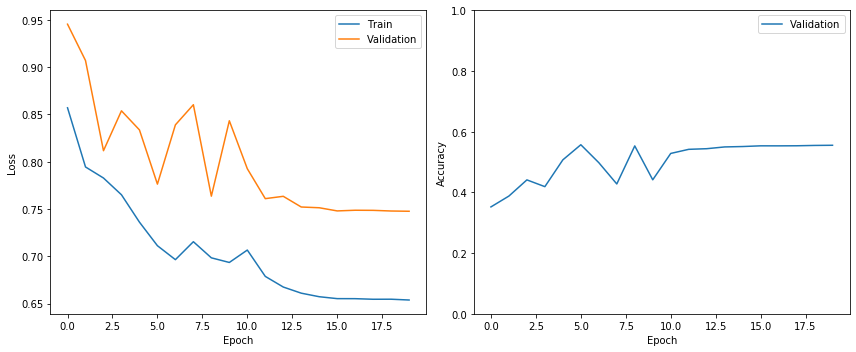

In [93]:
plot_train_history(summaries)

Text(0, 0.5, 'Learning rate')

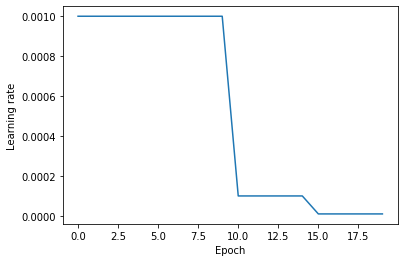

In [94]:
# Plot the learning rate
plt.figure()
plt.plot(summaries.lr)
plt.xlabel('Epoch')
plt.ylabel('Learning rate')

## Load the trained model

In [7]:
# Find the best epoch
best_idx = summaries.valid_loss.idxmin()
summaries.loc[[best_idx]]

,lr,train_loss,l1,l2,epoch,train_time,valid_loss,valid_acc,valid_time
19,0.00001,0.653706,2745.694444,109.772975,19,74.183332,0.747591,0.555463,2.559959


In [8]:
# Build the trainer and load best checkpoint
trainer = get_trainer(output_dir=config['output_dir'], **config['trainer'])
trainer.build_model(optimizer_config=config['optimizer'], **config['model'])

best_epoch = summaries.epoch.loc[best_idx]
trainer.load_checkpoint(checkpoint_id=best_epoch)

print(trainer.model)
print('Parameters:', sum(p.numel() for p in trainer.model.parameters()))

GNNSegmentClassifier(
  (input_network): Sequential(
    (0): Linear(in_features=3, out_features=64, bias=True)
    (1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (2): Tanh()
  )
  (edge_network): EdgeNetwork(
    (network): Sequential(
      (0): Linear(in_features=134, out_features=64, bias=True)
      (1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (2): Tanh()
      (3): Linear(in_features=64, out_features=64, bias=True)
      (4): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (5): Tanh()
      (6): Linear(in_features=64, out_features=64, bias=True)
      (7): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (8): Tanh()
      (9): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (node_network): NodeNetwork(
    (network): Sequential(
      (0): Linear(in_features=201, out_features=64, bias=True)
      (1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (2): Tanh()
      (3): Linear(in_features=64, out_fea

## Evaluate the model on the test dataset

In [11]:
# Load the test dataset
n_test = 64
test_loader = get_test_data_loader(config, n_test=n_test)

In [12]:
%%time
# Apply the model
test_preds, test_targets = trainer.predict(test_loader)

CPU times: user 18.5 s, sys: 391 ms, total: 18.9 s
Wall time: 10.8 s


In [14]:
threshold = 0.5
test_metrics = compute_metrics(test_preds, test_targets, threshold=threshold)

print('Test set results with threshold of', threshold)
print('Accuracy:  %.4f' % test_metrics.accuracy)
print('Precision: %.4f' % test_metrics.precision)
print('Recall:    %.4f' % test_metrics.recall)

Test set results with threshold of 0.5
Accuracy:  0.5586
Precision: 0.3507
Recall:    0.9471


In [16]:
threshold = 0.8
test_metrics = compute_metrics(test_preds, test_targets, threshold=threshold)

print('Test set results with threshold of', threshold)
print('Accuracy:  %.4f' % test_metrics.accuracy)
print('Precision: %.4f' % test_metrics.precision)
print('Recall:    %.4f' % test_metrics.recall)

Test set results with threshold of 0.8
Accuracy:  0.7996
Precision: 0.5813
Recall:    0.6432


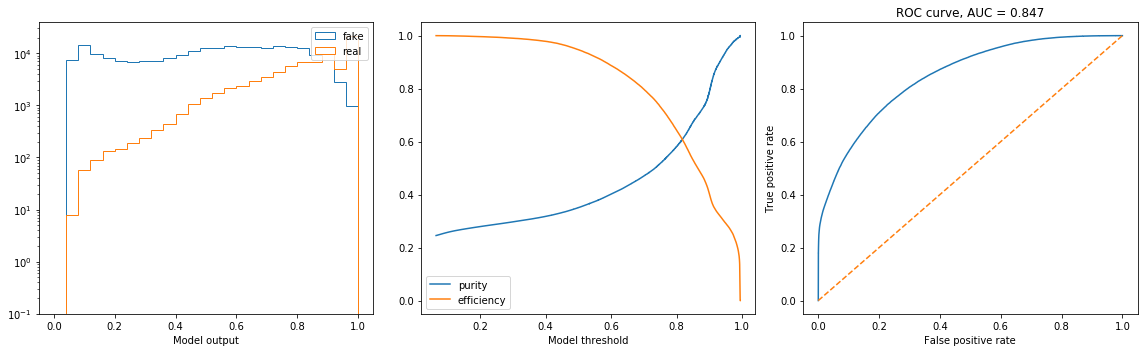

In [17]:
plot_metrics(test_preds, test_targets, test_metrics)

## Visualize predictions

In [18]:
n_phi_sections = 8
feature_scale = np.array([1000., np.pi / n_phi_sections, 1000.])

In [144]:
i = 1

g = test_loader.dataset[i]
e = g.edge_index.numpy()
x = g.x.numpy() * feature_scale
y = g.y.numpy()
o = test_preds[i].numpy()

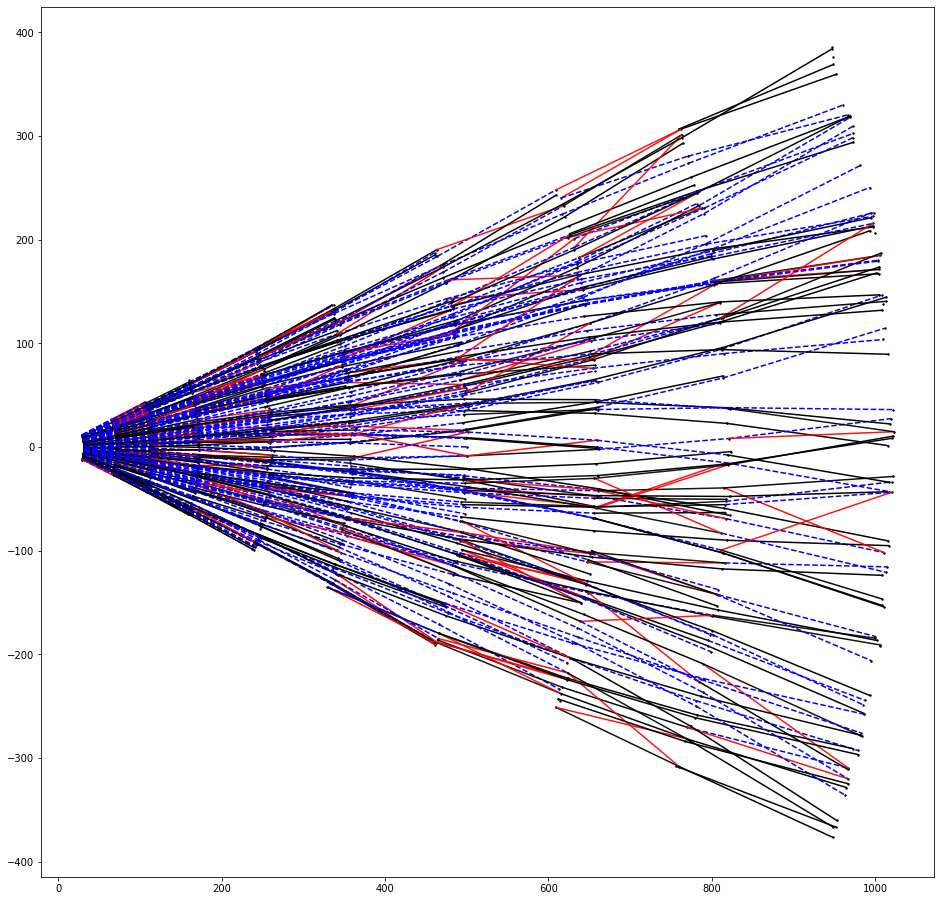

In [22]:
draw_sample_xy(x, e, o, y, cut=0.9);

## Writing data files

In [153]:
n_test = 10
test_loader = get_test_data_loader(config, n_test=n_test)
test_preds, test_targets = trainer.predict(test_loader)

In [155]:
test_preds

[tensor([0.5973, 0.2198, 0.5411,  ..., 0.6023, 0.7691, 0.8281]),
 tensor([0.4772, 0.4588, 0.4748,  ..., 0.7474, 0.5524, 0.7467]),
 tensor([0.7553, 0.6597, 0.1341,  ..., 0.9004, 0.9017, 0.9923]),
 tensor([0.5447, 0.5692, 0.5201,  ..., 0.7592, 0.7315, 0.7215]),
 tensor([0.8834, 0.0831, 0.5678,  ..., 0.9934, 0.9935, 0.9916]),
 tensor([0.6483, 0.1697, 0.1185,  ..., 0.9935, 0.9933, 0.9932]),
 tensor([0.5512, 0.1825, 0.2080,  ..., 0.8164, 0.8154, 0.8193]),
 tensor([0.6078, 0.6298, 0.6309,  ..., 0.6929, 0.1084, 0.6978]),
 tensor([0.6461, 0.5879, 0.5297,  ..., 0.8931, 0.9927, 0.9934]),
 tensor([0.6220, 0.2117, 0.6047,  ..., 0.8378, 0.9935, 0.9936])]

In [156]:
test_targets

[tensor([1., 0., 0.,  ..., 0., 0., 1.]),
 tensor([1., 0., 0.,  ..., 0., 0., 1.]),
 tensor([1., 0., 0.,  ..., 0., 1., 1.]),
 tensor([1., 0., 0.,  ..., 0., 0., 1.]),
 tensor([0., 0., 1.,  ..., 1., 1., 1.]),
 tensor([1., 0., 0.,  ..., 1., 1., 1.]),
 tensor([1., 0., 0.,  ..., 0., 0., 1.]),
 tensor([1., 0., 0.,  ..., 0., 0., 1.]),
 tensor([1., 0., 0.,  ..., 1., 1., 1.]),
 tensor([0., 0., 0.,  ..., 1., 1., 1.])]

In [146]:
g = test_loader.dataset
e = g.edge_index.numpy()
x = g.x.numpy() * feature_scale
y = g.y.numpy()
o = test_preds[i].numpy()

AttributeError: 'Subset' object has no attribute 'edge_index'

In [63]:
e = torch.tensor(e)

In [64]:
x = torch.tensor(x)

In [23]:
y

array([1., 0., 0., ..., 0., 0., 1.], dtype=float32)

In [65]:
o

array([0.4662472 , 0.49123594, 0.51943   , ..., 0.8341328 , 0.83358026,
       0.7764561 ], dtype=float32)

In [145]:
e.shape

(2, 6473)

In [67]:
start, end = e

In [71]:
p = torch.cat([x[start], x[end]], dim=1)

In [49]:
m = nn.Sigmoid()
m(torch.randn(2))

tensor([0.3789, 0.5419])

In [61]:
start, end = new_e

In [87]:
new_x = torch.cat([x, x], dim=-1)

In [88]:
new_x.shape

torch.Size([1256, 6])

In [84]:
m = scatter_add(p[:, None] * new_x[start], end, dim=0, dim_size=x.shape[0])

In [85]:
m.shape

torch.Size([1256, 3379, 6])

In [82]:
p.shape, new_x.shape

(torch.Size([3379, 6]), torch.Size([1256, 6]))

In [33]:
A = np.array([[1,1,2,2,5,3,4],[2,5,3,4,2,6,6]])
start, end = A
A

array([[1, 1, 2, 2, 5, 3, 4],
       [2, 5, 3, 4, 2, 6, 6]])

In [40]:
A.shape[1]

7

In [34]:
np.transpose(np.array([[key2,key1] for key1, val1 in enumerate(start) for key2, val2 in enumerate(end) if val1 == val2]))

array([[0, 4, 0, 4, 1, 2, 3],
       [2, 2, 3, 3, 4, 5, 6]])

In [25]:
g

Data(edge_index=[2, 6473], w=[6473], x=[1732, 3], y=[6473])

In [26]:
g.w

tensor([1., 1., 1.,  ..., 1., 1., 1.])

In [61]:
Ri = np.zeros((np.max(A)+1, A.shape[1]))
Ro = np.zeros((np.max(A)+1, A.shape[1]))

In [62]:
Ri[A[0,:], np.arange(A.shape[1])]=1
Ro[A[1,:], np.arange(A.shape[1])]=1

In [71]:
Riwhere = [np.nonzero(t)[0] for t in Ri]
Rowhere = [np.nonzero(t)[0] for t in Ro]
Riwhere, Rowhere

([array([], dtype=int64),
  array([0, 1]),
  array([2, 3]),
  array([5]),
  array([6]),
  array([4]),
  array([], dtype=int64)],
 [array([], dtype=int64),
  array([], dtype=int64),
  array([0, 4]),
  array([2]),
  array([3]),
  array([1]),
  array([5, 6])])

In [85]:
np.array(np.meshgrid([0,1],[2,3])).T.reshape(-1,2)

array([[0, 2],
       [0, 3],
       [1, 2],
       [1, 3]])

In [91]:
E = [np.stack(np.meshgrid(j, i),-1).reshape(-1,2) for i,j in zip(Riwhere, Rowhere)]
E

[array([], shape=(0, 2), dtype=int64),
 array([], shape=(0, 2), dtype=int64),
 array([[0, 2],
        [4, 2],
        [0, 3],
        [4, 3]]),
 array([[2, 5]]),
 array([[3, 6]]),
 array([[1, 4]]),
 array([], shape=(0, 2), dtype=int64)]

In [113]:
Esmall = np.array(E)[np.array([y.size>0 for y in E])]

In [100]:
np.array([y.size>0 for y in E])

array([False, False,  True,  True,  True,  True, False])

In [126]:
Esmall[0]

array([[0, 2],
       [4, 2],
       [0, 3],
       [4, 3]])

In [127]:
Esmall[1]

array([[2, 5]])

In [131]:
np.concatenate(E).T

array([[0, 4, 0, 4, 2, 3, 1],
       [2, 2, 3, 3, 5, 6, 4]])

In [142]:
import numpy as np, numpy.random as nprand, time, bisect

bigN = 50000
smallN = 1000
maxn = 10000
nprand.seed(1)  
bigArr = nprand.randint(0, maxn, size=bigN)
smallArr = nprand.randint(0, maxn, size=smallN)

# brute force 
t1 = time.time()
for i in range(len(smallArr)):
    inds = np.where(bigArr == smallArr[i])[0]
t2 = time.time()
print("Brute", t2-t1)

# not brute force (like nested loop with index scan)
t1 = time.time()
sortedind = np.argsort(bigArr)
sortedbigArr = bigArr[sortedind]
for i in range(len(smallArr)):
    i1 = bisect.bisect_left(sortedbigArr, smallArr[i])
    i2 = bisect.bisect_right(sortedbigArr, smallArr[i])
    inds = sortedind[i1:i2]
t2=time.time()
print("Non-brute", t2-t1)

Brute 0.04909992218017578
Non-brute 0.031980276107788086


In [143]:
tic = time.time()
Ri = np.zeros((maxn+1, bigArr.shape[0]))
Ro = np.zeros((maxn+1, smallArr.shape[0]))
Ri[bigArr[:], np.arange(bigArr.shape[0])]=1
Ro[smallArr[:], np.arange(smallArr.shape[0])]=1
Riwhere = [np.nonzero(t)[0] for t in Ri]
Rowhere = [np.nonzero(t)[0] for t in Ro]
Riwhere, Rowhere
E = [np.stack(np.meshgrid(j, i),-1).reshape(-1,2) for i,j in zip(Riwhere, Rowhere)]
triplets2 = np.concatenate(E).T
toc = time.time()
print("Elapsed: ", toc-tic, " triplets2 shape: ", triplets2.shape)

Elapsed:  14.358487844467163  triplets2 shape:  (2, 5013)


In [6]:
from datasets import graph

In [7]:
input = graph.load_graph('/mnt/c/Users/Daniel/Dropbox/Research/Publications/ExaTrkX/data/hitgraphs_small_000/event000001000_g000.npz')

In [8]:
input.Ri

array([[0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [9]:
input_dir = '/mnt/c/Users/Daniel/Dropbox/Research/Publications/ExaTrkX/data/hitgraphs_small_000'
filenames = [os.path.join(input_dir, f) for f in os.listdir(input_dir)
                         if f.startswith('event') and not f.endswith('_ID.npz') and not f.endswith('_pid.npz')]

In [14]:
%%time
inputs = graph.load_graphs(filenames)

CPU times: user 2.39 s, sys: 6.38 s, total: 8.77 s
Wall time: 16.6 s


In [13]:
len(inputs)

400

In [15]:
pid_filenames = [os.path.join(input_dir, f) for f in os.listdir(input_dir)
                         if f.startswith('event') and f.endswith('_pid.npz')]